<a href="https://colab.research.google.com/github/chi-hun/dacon/blob/main/%EC%9B%94%EA%B0%84_%EB%8D%B0%EC%9D%B4%EC%BD%98_%EC%98%88%EC%88%A0_%EC%9E%91%ED%92%88_%ED%99%94%EA%B0%80_%EB%B6%84%EB%A5%98_AI_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

월간 데이콘 예술 작품 화가 분류 AI 경진대회 https://dacon.io/competitions/official/236006/overview/description

# module

In [2]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import glob
import cv2
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
import tensorflow as tf
from tensorflow.keras import layers

In [3]:
!unzip -qq  '/content/drive/MyDrive/Colab Notebooks/데이콘/월간 데이콘 예술 작품 화가 분류/open.zip'

# EDA

In [6]:
train = pd.read_csv('/content/train.csv', index_col='id')

In [4]:
train.head()

,img_path,artist
id,,
0,./train/0000.jpg,Diego Velazquez
1,./train/0001.jpg,Vincent van Gogh
2,./train/0002.jpg,Claude Monet
3,./train/0003.jpg,Edgar Degas
4,./train/0004.jpg,Hieronymus Bosch


In [7]:
train['img_path'] = sorted(glob.glob('/content/train/*'))

In [8]:
def img_size(x):
    img = cv2.imread(x)
    return img.shape

train['img_shape'] = train['img_path'].apply(img_size)

KeyboardInterrupt: ignored

In [ ]:
def image_width(x):
    return x[1]
train['width'] = train['img_shape'].apply(image_width)

def image_height(x):
    return x[0]
train['height'] = train['img_shape'].apply(image_height)

In [8]:
train.head()

,img_path,artist,img_shape,width,height
id,,,,,
0,/content/train/0000.jpg,Diego Velazquez,"(1300, 1024, 3)",1024,1300
1,/content/train/0001.jpg,Vincent van Gogh,"(1024, 568, 3)",568,1024
2,/content/train/0002.jpg,Claude Monet,"(722, 1024, 3)",1024,722
3,/content/train/0003.jpg,Edgar Degas,"(836, 1053, 3)",1053,836
4,/content/train/0004.jpg,Hieronymus Bosch,"(845, 782, 3)",782,845


In [ ]:
train['width'].max(), train['width'].min(), train['height'].max(), train['height'].min() 

(4096, 204, 3826, 226)

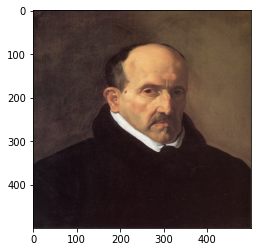

In [16]:
img = cv2.cvtColor(cv2.imread(train.img_path[0]), cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (500,500))
plt.imshow(img)

In [ ]:
transfomer = A.Compose([A.RandomCrop(250, 250)])

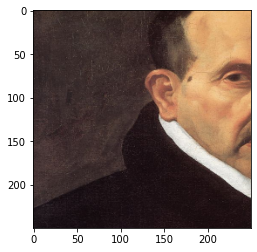

In [ ]:
image = transfomer(image=img)['image']
plt.imshow(image)

In [ ]:
artist_info = pd.read_csv('/content/artists_info.csv')
artist_info.head()

,name,years,genre,nationality
0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian
1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian
2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican
3,Claude Monet,1840 - 1926,Impressionism,French
4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian


In [ ]:
train.loc[3896]

,img_path,artist,img_shape,width,height
id,,,,,
3896,/content/train/3896.jpg,Edgar Degas,"(709, 1024, 3)",1024,709
3896,/content/train/3986.jpg,Titian,"(753, 1024, 3)",1024,753


In [ ]:
train.loc[train['img_path'] == '/content/train/3896.jpg', 'artist'] = 'Titian'
train.loc[train['img_path'] == '/content/train/3986.jpg', 'artist'] = 'Alfred Sisley'

In [ ]:
train.artist.nunique()

50

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


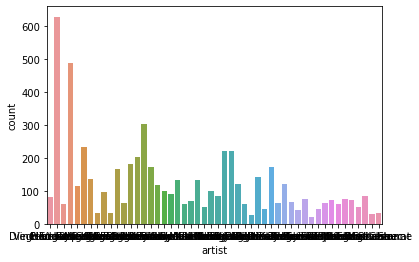

In [ ]:
sns.countplot(train.artist)
plt.show()

In [10]:
train.to_csv('train_csv.csv', index=False)

# data_maker

In [9]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이콘/월간 데이콘 예술 작품 화가 분류/train_csv.csv')

In [50]:
class data_maker(tf.keras.utils.Sequence):
    def __init__(self, path, label=None, img_size = 250, batch = 32, train = True, shuffle = False):
        self.path = path
        self.label = label
        self.img_size = img_size
        self.batch = batch
        self.train = train
        self.shuffle = shuffle

        if self.shuffle:
            self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.path) / self.batch))

    def __getitem__(self, index):
        path_sel = self.path[index * self.batch : (index + 1) * self.batch]
        if self.label is not None:
            label_sel = self.label[index * self.batch : (index+1) * self.batch]
        
        transfomer = A.Compose([A.RandomCrop(self.img_size, self.img_size)])
        image = np.zeros((len(path_sel), self.img_size, self.img_size, 3), dtype=np.float32)
        for i in range(len(path_sel)):
            img = cv2.cvtColor(cv2.imread(path_sel[i]), cv2.COLOR_BGR2RGB)
            if self.train:
                img = cv2.resize(img, (500,500)) / 255
                img = transfomer(image=img)['image']
            else:
                img = cv2.resize(img, (self.img_size, self.img_size)) / 255

            image[i] = img

        if self.label is not None:
            return image, np.array(label_sel)
        else:
            return image

    def on_epoch_end(self):
        if self.shuffle:
            self.path, self.label = sklearn.utils.shuffle(self.path, self.label)
        else:
            pass

In [11]:
x_train = train['img_path']
y_train = pd.get_dummies(train['artist'])
classes = y_train.columns

x_ttrain, x_ttest, y_ttrain, y_ttest = train_test_split(x_train, y_train, test_size=0.1, stratify=y_train)
x_ttrain.shape, x_ttest.shape, y_ttrain.shape, y_ttest.shape

((5319,), (592,), (5319, 50), (592, 50))

In [12]:
img_size = 250
train_ds = data_maker(x_ttrain.values, y_ttrain.values, img_size=img_size, batch=32, train=True, shuffle=True)
val_ds = data_maker(x_ttest.values, y_ttest.values, img_size=img_size, batch=32, train=True, shuffle=False)

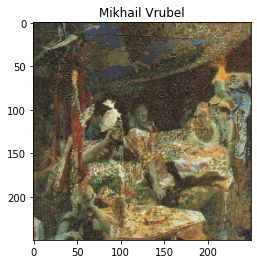

In [13]:
plt.imshow(train_ds[0][0][0])
plt.title(classes[np.argmax(train_ds[0][1][0])])
plt.show()

# traning

## make cnn

In [88]:
def model_make1():
    inputs = layers.Input(shape=(img_size, img_size, 3))
    x = layers.Conv2D(32, 3, 1, activation='relu')(inputs)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(64, 3, 1, activation='relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(128, 3, 1, activation='relu')(x)
    x = layers.MaxPool2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(50, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [90]:
model = model_make1()
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 124, 124, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 61, 61, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 59, 59, 128)       7385

In [91]:
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [92]:
his = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
167/167 [==============================] - 437s 3s/step - loss: 3.6323 - accuracy: 0.1043 - val_loss: 3.4712 - val_accuracy: 0.1166
Epoch 2/20
167/167 [==============================] - 433s 3s/step - loss: 3.3988 - accuracy: 0.1491 - val_loss: 3.2777 - val_accuracy: 0.1689
Epoch 3/20
167/167 [==============================] - 429s 3s/step - loss: 3.2689 - accuracy: 0.1716 - val_loss: 3.2403 - val_accuracy: 0.1672
Epoch 4/20
167/167 [==============================] - 435s 3s/step - loss: 3.1389 - accuracy: 0.1863 - val_loss: 3.0536 - val_accuracy: 0.2027
Epoch 5/20
167/167 [==============================] - 434s 3s/step - loss: 3.0130 - accuracy: 0.2098 - val_loss: 2.9675 - val_accuracy: 0.1993
Epoch 6/20
 28/167 [====>.........................] - ETA: 5:46 - loss: 2.9676 - accuracy: 0.2087

KeyboardInterrupt: ignored

## efficientnet

In [19]:
pre_layer = tf.keras.applications.efficientnet.preprocess_input
base_model = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = True

In [20]:
def model_make2():
    inputs = layers.Input(shape=(img_size, img_size, 3))
    x = pre_layer(inputs)
    x = base_model(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(50, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [26]:
model = model_make2()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 8, 8, 1280)       4049571   
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 1024)              1311744   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 512)               524800    
                                                           

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [28]:
with tf.device('/GPU0:'):
    his = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
167/167 [==============================] - 123s 682ms/step - loss: 3.7276 - accuracy: 0.1126 - val_loss: 3.5751 - val_accuracy: 0.1959
Epoch 2/10
167/167 [==============================] - 112s 670ms/step - loss: 3.1992 - accuracy: 0.2948 - val_loss: 2.8407 - val_accuracy: 0.3851
Epoch 3/10
167/167 [==============================] - 113s 673ms/step - loss: 2.6890 - accuracy: 0.4208 - val_loss: 2.8357 - val_accuracy: 0.3953
Epoch 4/10
167/167 [==============================] - 112s 671ms/step - loss: 2.2375 - accuracy: 0.5349 - val_loss: 2.2291 - val_accuracy: 0.5186
Epoch 5/10
167/167 [==============================] - 113s 675ms/step - loss: 1.9231 - accuracy: 0.5977 - val_loss: 1.8554 - val_accuracy: 0.5997
Epoch 6/10
167/167 [==============================] - 114s 681ms/step - loss: 1.6640 - accuracy: 0.6518 - val_loss: 1.7030 - val_accuracy: 0.6182
Epoch 7/10
167/167 [==============================] - 113s 674ms/step - loss: 1.4288 - accuracy: 0.6875 - val_loss: 1.5710 -

In [56]:
with tf.device('/GPU:0'):
    his = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
167/167 [==============================] - 117s 702ms/step - loss: 0.9735 - accuracy: 0.7691 - val_loss: 1.1763 - val_accuracy: 0.6909
Epoch 2/10
 44/167 [======>.......................] - ETA: 1:17 - loss: 0.8745 - accuracy: 0.7805

KeyboardInterrupt: ignored

In [57]:
model.save('model_eff.h5')

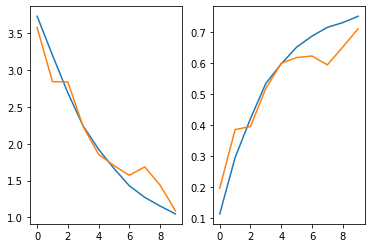

In [53]:
plt.subplot(1,2,1)
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.subplot(1,2,2)
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.show()

# sub

In [41]:
submission = pd.read_csv('/content/sample_submission.csv')

In [51]:
test_path = sorted(glob.glob('/content/test/*'))
test_ds = data_maker(test_path, img_size=img_size, batch=32, train=False, shuffle=False)
pre = classes[np.argmax(model.predict(test_ds), axis=1)]

In [47]:
submission['artist'] = pre
submission.to_csv('sub.csv', index=False)